In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_palette("bright")
import h5py

from sklearn.cluster import KMeans, MeanShift
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output # For looping but only printing each loop

import tomo_challenge as tc

import time

np.random.seed(1985)
gen = np.random.RandomState(seed=1985)

In [56]:
d_loc = "data_buzzard"
x_train = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/training.hdf5", "griz", colors=True, errors=True))
z_train = tc.load_redshift(f"{d_loc}/training.hdf5")

In [57]:
color_data = x_train[["r", "gr", "ri", "rz"]].to_numpy()
errs = x_train[["r_err"]].to_numpy()

err_thresh = 0.01
err_cond = errs >= err_thresh
weights = np.where(errs < err_thresh, 1, 1/errs**2)
weights[err_cond] = weights[err_cond] / np.max(weights[err_cond])

In [58]:
# Make the mean zero then find the covariance matrix
# divde by len-1 because sample and not population covariance
# First line is unweighted mean, second is the weighted average.
# color_shifted = color_data - np.mean(color_data, axis=0)
color_shifted = color_data - np.average(color_data[:,0].reshape(-1, 1), weights=weights)
cov = color_shifted.T @ color_shifted / (color_shifted.shape[0] - 1)

# Find the eigen values and eigen vectors of the covariance matrix
# The eigen vectors are vertical!
# Eigen vectors are principal components of dataset
eigen_variance, eigen_matrix = np.linalg.eig(cov)

24.353793818665167
22.428384558445664


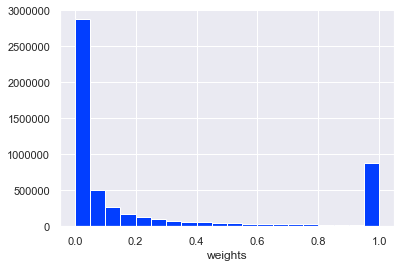

In [59]:
# plt.hist(errs[errs < 30], bins=15)
plt.hist(weights, bins=20)
plt.xlabel("weights")
# print(weights.max())
# print(weights.min())

print(np.mean(color_data[:,0]))
print(np.average(color_data[:,0].reshape(-1, 1), weights=weights))

In [60]:
def find_eigenvector(data, weights=None):
    # Start with position 1985. 1985 is the year my favourite
    # movie came out. No other reason than that. 
    phi = data[1985].reshape(1, -1)
    
    if weights is None:
        weights = np.ones_like(phi)

    thresh = 1e-6
    cond = False
    i = 0
    while not cond:
        # Find the coefficients that match the eigen vector to the data vector
        coeffs = data @ phi.T

        # Project the data along phi axis by multiplying the data by the coefficient
        proj = data * coeffs * weights

        # Sum all the projected ones to find the new eigenvector and then divide by the
        # length of the vector to reduce it to unit vector length.
        phi_new = np.sum(proj, axis=0)
        phi_new = phi_new / np.linalg.norm(phi_new)

        # If all of the dimensions changes by less than thresh then the
        # condition is set to true and the loop breaks
        cond = np.all((phi_new - phi) < thresh)

        phi = phi_new.reshape(1, -1)
        i += 1
    print("Iterations:", i + 1)
    return phi

In [61]:
eigs = []
num_eigs = 4
eigs = np.zeros((num_eigs, color_shifted.shape[1]))
temp_data = np.copy(color_shifted)
for i in range(num_eigs):
    v = find_eigenvector(temp_data, weights)
    eigs[:,i] = (v)
    
    # Subtract the projections of the first eigen vector to start finding the next one.
    coeffs = temp_data @ v.T
    temp_data = temp_data - coeffs * v

print(eigs)
print(eigen_matrix)
# Closeness assertions for testing purposes.
# assert np.allclose(eigs[:,0], eigen_matrix[:,0]) or np.allclose(-eigs[:,0], eigen_matrix[:,0], atol=1e-3)
# assert np.allclose(eigs[:,1], eigen_matrix[:,1]) or np.allclose(-eigs[:,1], eigen_matrix[:,1], atol=1e-3)
# assert np.allclose(eigs[:,2], eigen_matrix[:,2]) or np.allclose(-eigs[:,2], eigen_matrix[:,2], atol=1e-3)
# assert np.allclose(eigs[:,3], eigen_matrix[:,3]) or np.allclose(-eigs[:,3], eigen_matrix[:,3], atol=1e-3)

Iterations: 4
Iterations: 6
Iterations: 10
Iterations: 3
[[-6.35391296e-06  9.98621029e-01  5.24795563e-02  1.39145577e-03]
 [-5.72169974e-01 -4.27424827e-02  8.15327242e-01 -7.76922706e-02]
 [-5.83377418e-01  1.67390639e-02 -3.38168798e-01  7.38263135e-01]
 [-5.76448011e-01  2.54739853e-02 -4.67043090e-01 -6.70022029e-01]]
[[-5.11780422e-02  9.98505004e-01 -1.91975676e-02  1.38055493e-04]
 [ 5.70992833e-01  4.48763546e-02  8.12694711e-01  1.07147579e-01]
 [ 5.82502181e-01  2.39676148e-02 -3.11660532e-01 -7.50322914e-01]
 [ 5.76228429e-01  1.99855923e-02 -4.91961861e-01  6.52330362e-01]]


[1.41493359e+03 2.17198129e+00 3.96161682e-01 8.84372958e-02]
[0.99812599 0.99965815 0.99993761 1.        ]


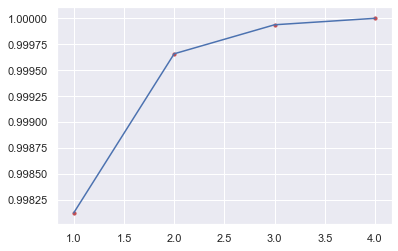

In [62]:
# Plots the amount of variance in the data explained by the number
# of principal components chosen.
print(eigen_variance)
x = np.arange(0, len(eigen_variance)) + 1
y = np.cumsum(eigen_variance) / np.sum(eigen_variance)

plt.plot(x, y, c="b")
plt.scatter(x, y, s=10, c="r")
print(y)

In [63]:
# The selection of principal axis vectors that will reduce dimensionality
reducer = eigs[:, 0:2]
# reducer = eigen_matrix[0:2].T
data_reduced = color_data @ reducer

# I took this cut from the random forest example.
# I cut after doing the PCA in case the cut changes the
# principal axes and I want to avoid that.
cut = np.random.uniform(0, 1, data_reduced.shape[0]) < 0.10
data_cut =  data_reduced[cut]

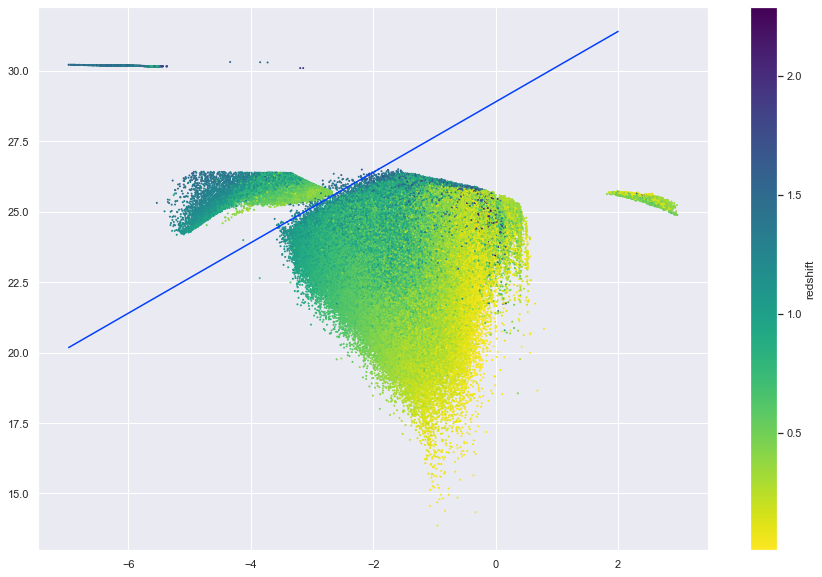

In [64]:
fig, ax = plt.subplots(figsize=(15, 10))

# Plotting data itself.
plt.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=z_train[cut], cmap="viridis_r")
plt.colorbar().set_label("redshift")

# This is linear so we only need like 3 points
x_reg = np.linspace(np.min(data_reduced[:, 0]), 2, 3)
# y_reg = x_reg * 5/4 + 27.5 + .22 # DC2 regression
def reg(x):
    return (x + 2) * 5/4 + 27.5 - 1.1
y_reg = reg(x_reg) # Buzzard regression

plt.plot(x_reg, y_reg)

In [65]:
cat1 = data_cut[:, 1] > 28
cat3 = data_cut[:, 0] > 1.5
cat2 = data_cut[:, 1] < reg(data_cut[:, 0])
cat2 = cat2 & np.invert(cat3)

categories = (cat1 + 2*cat2 + 3*cat3)

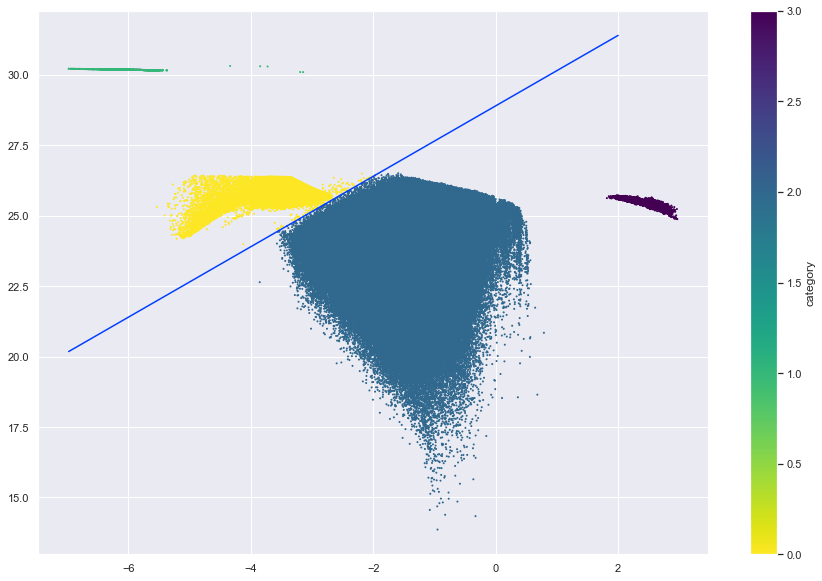

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))

# Plotting data itself.
plt.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=categories, cmap="viridis_r")
plt.colorbar().set_label("category")

plt.plot(x_reg, y_reg)
plt.savefig("split.png")

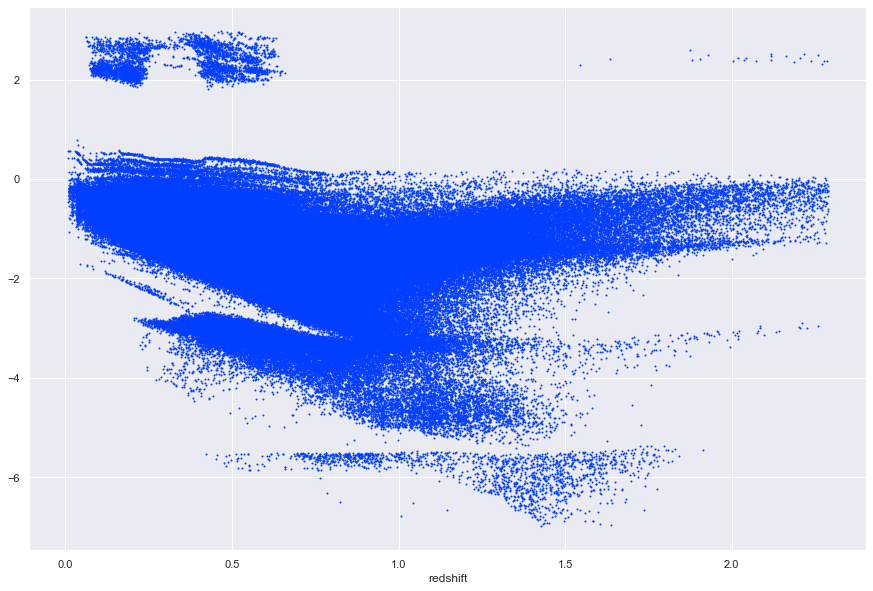

In [67]:
# Plotting the x coordinate versus the redshift since they seem roughly correlated
fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(z_train[cut], data_cut[:, 0], s=1, cmap="viridis_r")

plt.xlabel("redshift")
plt.savefig("redshift.png", dpi=128)

In [68]:
n_bins = 3
# Find the edges that split the redshifts into n_z bins of
# equal number counts in each
p = np.linspace(0, 100, n_bins + 1)
z_edges = np.percentile(z_train, p)

training_bin = np.zeros_like(data_reduced[:, 0])

# Now find all the objects in each of these bins
for i in range(n_bins):
    z_low = z_edges[i]
    z_high = z_edges[i + 1]
    training_bin[(z_train > z_low) & (z_train <= z_high)] = i

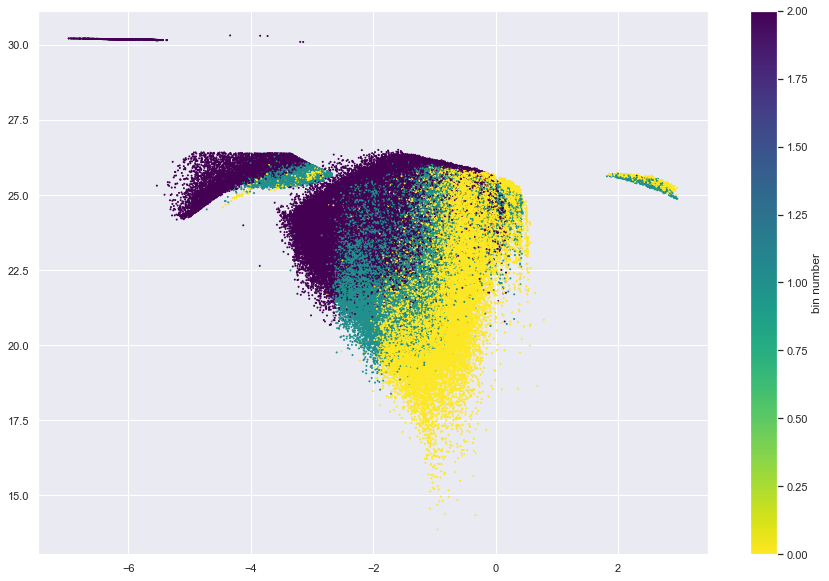

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))

# Plotting data itself.
plt.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=training_bin[cut], cmap="viridis_r")
plt.colorbar().set_label("bin number")

# plt.plot(x_reg, y_reg)
# plt.title("buzzard bins vs wPCA space")
# plt.savefig("buzzard bins.png", bbox_inches="tight", dpi=128)

In [70]:
color_cut = color_data[cut]
forests = []

# Must run to max + 1 because we need to include the last category
for i in range(np.max(categories) + 1):
    temp_classifier = RandomForestClassifier()

    # The y to predict is the bin number, the x input is the (2-d) data
    t0 = time.perf_counter()
    temp_classifier.fit(color_cut[categories == i], training_bin[cut][categories == i])
    duration = time.perf_counter() - t0
    
    forests.append(temp_classifier)
    print(f"Classifier {i} trained in {duration} seconds")

Classifier 0 trained in 12.33198390599864 seconds
Classifier 1 trained in 0.6205731590016512 seconds
Classifier 2 trained in 355.9216425580016 seconds
Classifier 3 trained in 1.1156412400014233 seconds


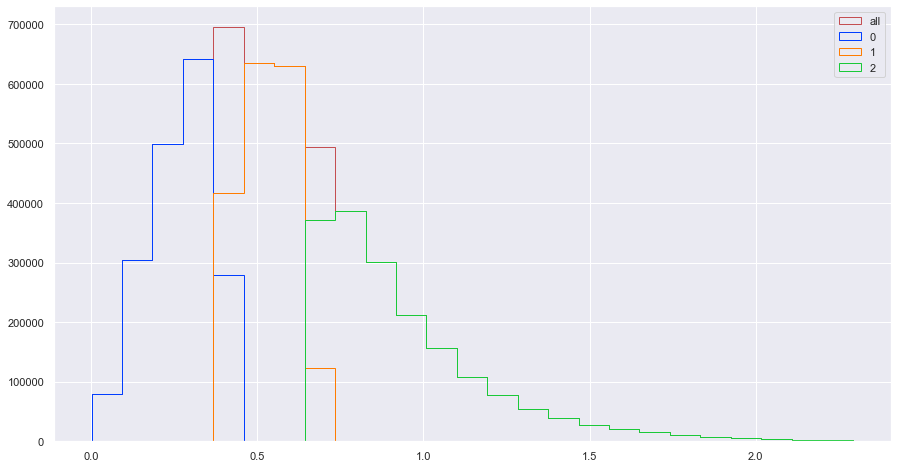

In [71]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_train, bins=25, histtype="step", color="r", label="all")

for i in range(0, n_bins):
    plt.hist(z_train[training_bin == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [72]:
x_valid = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/validation.hdf5", "griz", colors=True))
z_valid = tc.load_redshift(f"{d_loc}/validation.hdf5")

data_valid = x_valid[["r", "gr", "ri", "rz"]].to_numpy()
data_valid_r = data_valid @ reducer

In [73]:
# Predict the categories of the full and uncut dataset and then make a histogram
cat1 = data_valid_r[:, 1] > 28
cat3 = data_valid_r[:, 0] > 2
cat2 = data_valid_r[:, 1] < reg(data_valid_r[:, 0])
cat2 = cat2 & np.invert(cat3)

categories_valid = (cat1 + 2*cat2 + 3*cat3)

# Bins of the right length
y_valid = np.zeros_like(categories_valid)

for i in range(np.max(categories_valid) + 1):
    temp_classifier = forests[i]
    # Condition that fits this classifier
    cond = categories_valid == i
    
    t0 = time.perf_counter()
    pred_bins = temp_classifier.predict(data_valid[cond])
    duration = time.perf_counter() - t0
        
    y_valid[cond] = pred_bins
    
    print(f"Classified data points in category {i} in  {duration} seconds")

Classified data points in category 0 in  15.299013392999768 seconds
Classified data points in category 1 in  0.607854819005297 seconds
Classified data points in category 2 in  377.8661416870018 seconds
Classified data points in category 3 in  1.3871736290020635 seconds


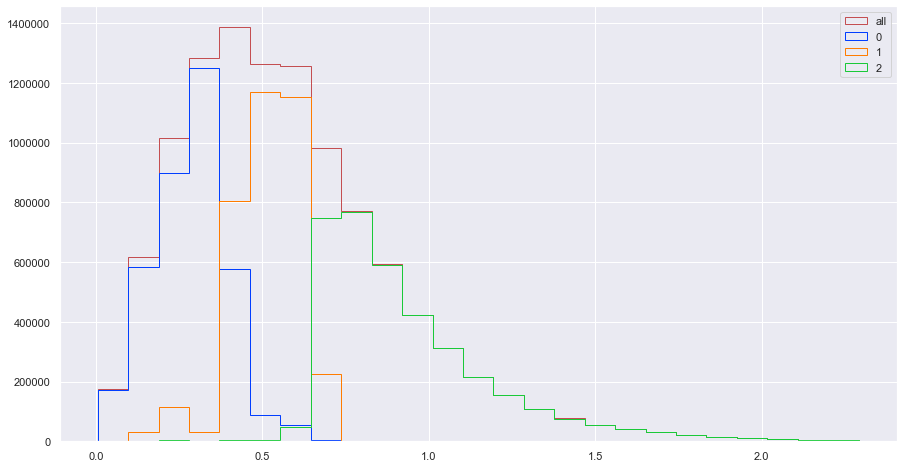

In [74]:
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_valid, bins=25, histtype="step", color="r", label="all")

for i in range(0, n_bins):
    plt.hist(z_valid[y_valid == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [ ]:
# Compute those scores.
print(f"Computing the scores for {n_bins} bins.")
t0 = time.perf_counter()
scores = tc.jc_compute_scores(y_valid, z_valid)
duration = time.perf_counter() - t0
print(f"{scores} in {duration} seconds")

Computing the scores for 3 bins.


/Users/dylan/miniconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype float64 requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/dylan/miniconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/dylan/miniconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype float6

{'SNR_ww': 255.722634525781, 'FOM_ww': 23.38846929372892, 'SNR_gg': 1140.4677554588447, 'FOM_gg': 562.0226227469069, 'SNR_3x2': 1141.959669084075, 'FOM_3x2': 1588.5623569928787} in 102.40529228099967 seconds